#### Code to extract data

**TODO** : 
- lung localizer to crop + window

In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [137]:
import os
import cv2
import glob
import gdcm
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm

In [138]:
from params import *

In [139]:
def read_xray(path):
    metadata = pydicom.read_file(path, stop_before_pixels=True)
    data = pydicom.read_file(path).pixel_array
    
    if metadata.PhotometricInterpretation == "MONOCHROME1":  # Inverted xray
        data = np.max(data) - data

    data = data - np.min(data)

    return data, metadata

In [174]:
def remove_padding(img):
    pad_y = (img > 30).mean(-1) > 0.1
    start_y = pad_y.tolist().index(True)
    end_y = pad_y[::-1].tolist().index(True)
    
    pad_x = (img > 30).mean(0) > 0.1
    start_x = pad_x.tolist().index(True)
    end_x = pad_x[::-1].tolist().index(True)
    
    if not np.any([start_x, end_x, start_y, end_y]):
        pad_y = (img < 255 - 30).mean(-1) > 0.1
        start_y = pad_y.tolist().index(True)
        end_y = pad_y[::-1].tolist().index(True)
        
        pad_x = (img < 255 - 30).mean(0) > 0.1
        start_x = pad_x.tolist().index(True)
        end_x = pad_x[::-1].tolist().index(True)
        
    img = img[start_y: len(img) - end_y, start_x: img.shape[1] - end_x]

    return img, (start_y, start_x)

In [175]:
def auto_windowing(img):
    pixels = img.flatten()
    pixels = pixels[pixels > 0]
    pixels = pixels[pixels < pixels.max()]
    start = np.percentile(pixels, 1)
    end = np.percentile(pixels, 99)
    
    img = np.clip(img, start, end)
    
    img = img - np.min(img)
    img = img / np.max(img)
    img = (img * 255).astype(np.uint8)

    return img, (start, end)

In [176]:
# VLIP : train/77539184cdaf/70852a51cfe9/24d0b38302d5.dcm

In [180]:
paths = glob.glob(TRAIN_DCM_PATH + "*/*/*.dcm")

path = TRAIN_DCM_PATH + "c29970048923/fc3ba5dcfffe/7b3e9f13d4e7.dcm"
path = TRAIN_DCM_PATH + "c29970048923/b67d36eb6f80/76c66ee8e58d.dcm"

path = TRAIN_DCM_PATH + "7dfd6afee3e9/9d4cc02b1e1d/1419506711be.dcm"

path = TRAIN_DCM_PATH + "49374ea79cdd/5fc4fbdcff53/b5a415f70aa9.dcm"
path = TRAIN_DCM_PATH + "b30c87707a75/6168aac73628/84135cf828e7.dcm"

# path = TRAIN_DCM_PATH + "230f160d4a7c/5981ea31f680/538525f017ca.dcm"
# path = TRAIN_DCM_PATH + "3f2ca41bae34/280e30eab869/1679d20fa0bc.dcm"
# path = TRAIN_DCM_PATH + "1c939db63c15/d412342fe6fa/282846988f20.dcm"

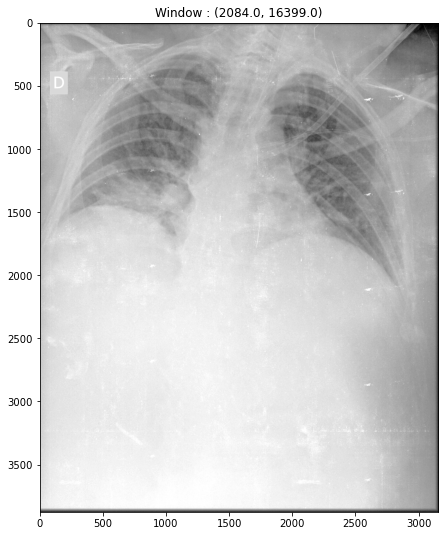

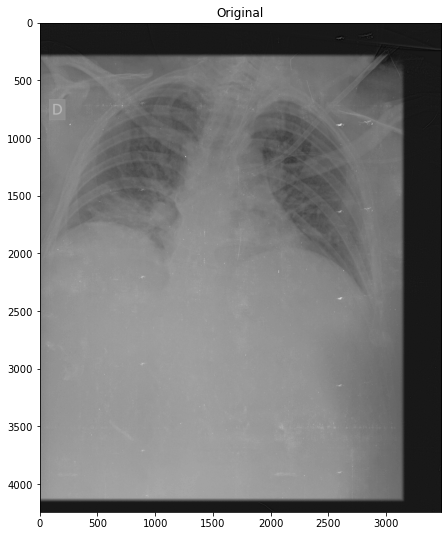

In [181]:
img, metadata = read_xray(path)

# sns.histplot(img.flatten())
# plt.axvline(end, c="salmon")
# plt.axvline(start, c="salmon")
# plt.show()

img_w, window = auto_windowing(img)
img_, starts = remove_padding(img_w)

plt.figure(figsize=(9, 9))
plt.imshow(img_, cmap="gray")
plt.title(f'Window : {window}')
plt.show()

plt.figure(figsize=(9, 9))
plt.imshow(img, cmap="gray")
plt.title(f'Original')
plt.show()

Image ../../../data/siim_covid/train/ba5b31cb8520/532c84b9c2d7/d01e8fd2c78d.dcm


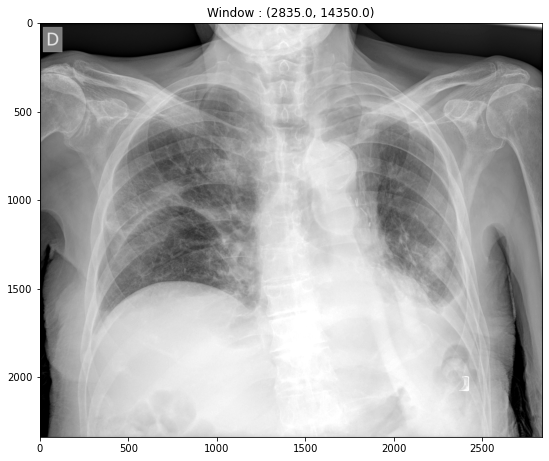

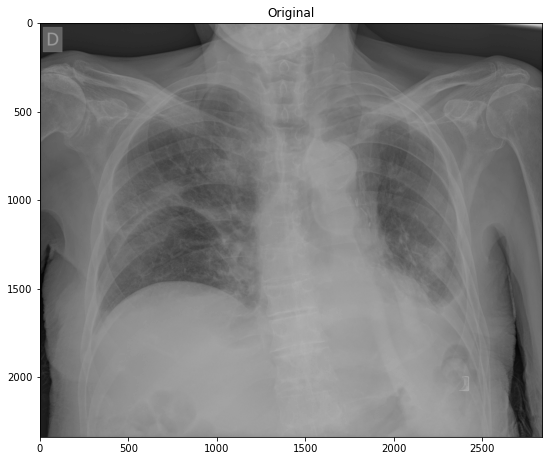

In [183]:
for path in np.random.choice(paths, 1):
    print(f"Image {path}")
    img, metadata = read_xray(path)

    # sns.histplot(img.flatten())
    # plt.axvline(end, c="salmon")
    # plt.axvline(start, c="salmon")
    # plt.show()

    img_, window = auto_windowing(img.copy())
    img_, starts = remove_padding(img_)

    plt.figure(figsize=(9, 9))
    plt.imshow(img_, cmap="gray")
    plt.title(f'Window : {window}')
    plt.show()

    plt.figure(figsize=(9, 9))
    plt.imshow(img, cmap="gray")
    plt.title(f'Original')
    plt.show()
    
#     break

### Params

In [187]:
if not os.path.exists(DCM_PATH):
    DCM_PATH = DATA_PATH

In [185]:
SIZE = 512
DATABASE = "train"
SAVE_DIR = DATA_PATH + f"{DATABASE}_{SIZE}/"

if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

In [186]:
df = pd.read_csv(DATA_PATH + "train_image_level.csv")

  0%|          | 0/6334 [00:00<?, ?it/s]

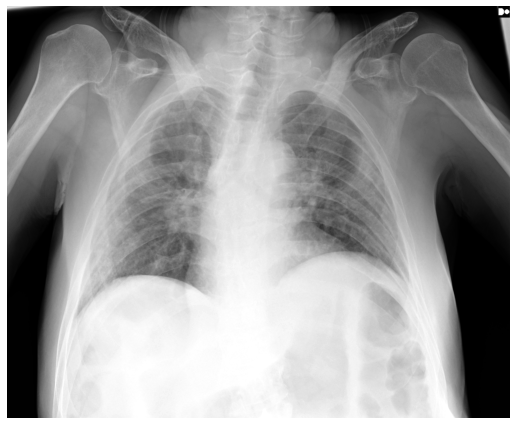

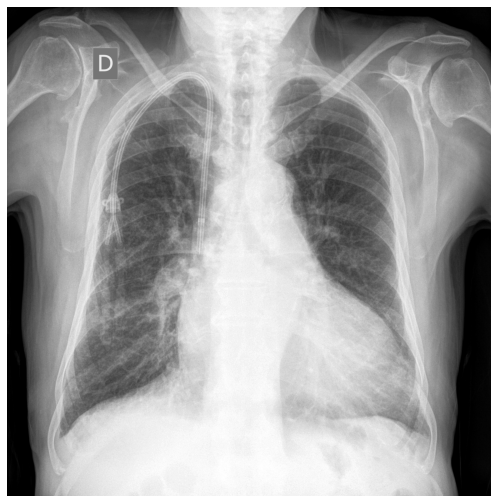

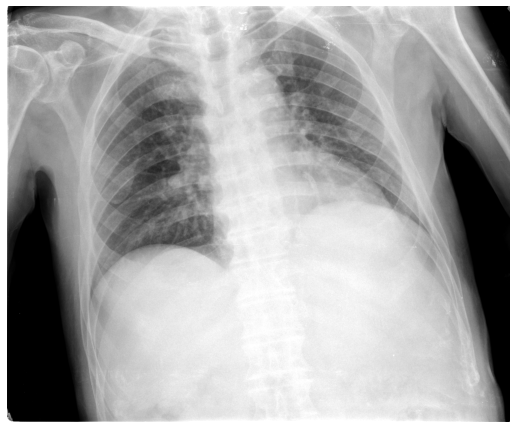

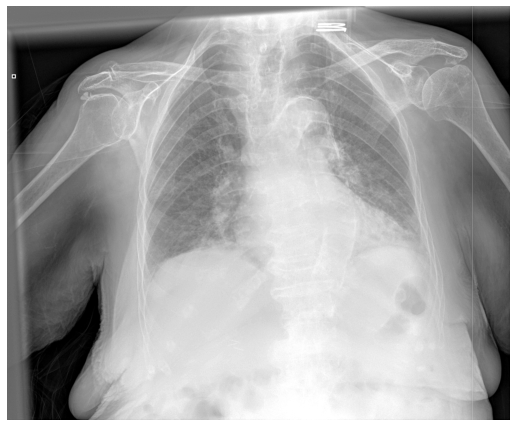

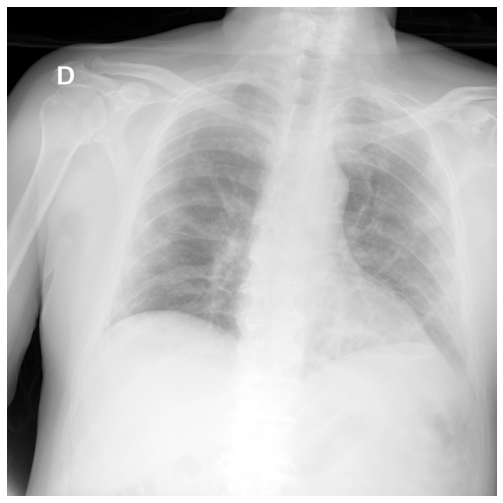

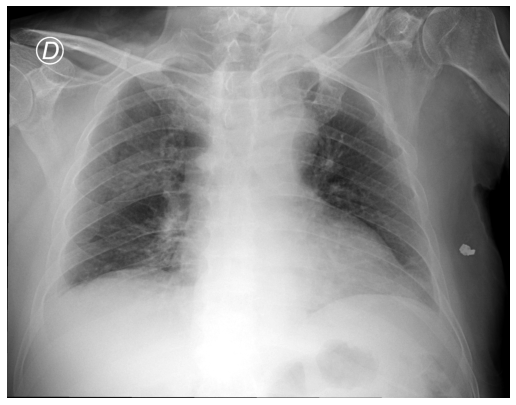

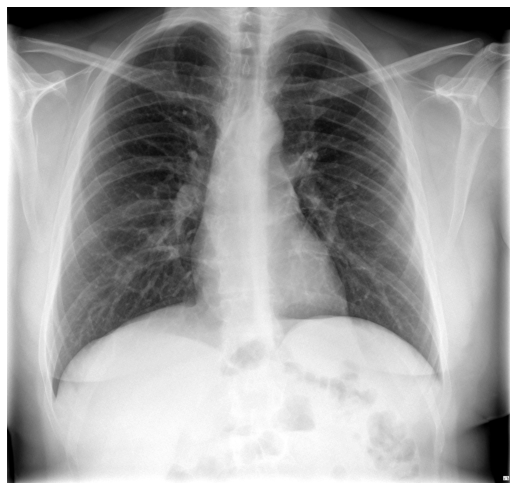

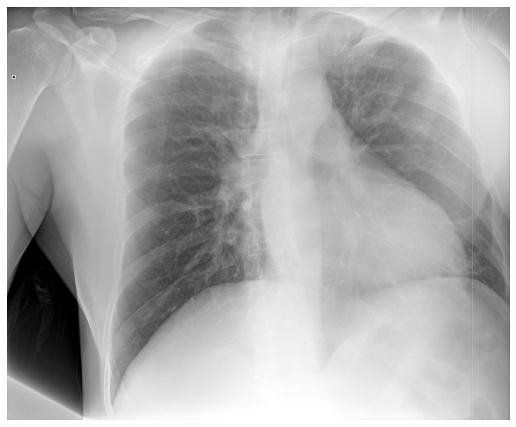

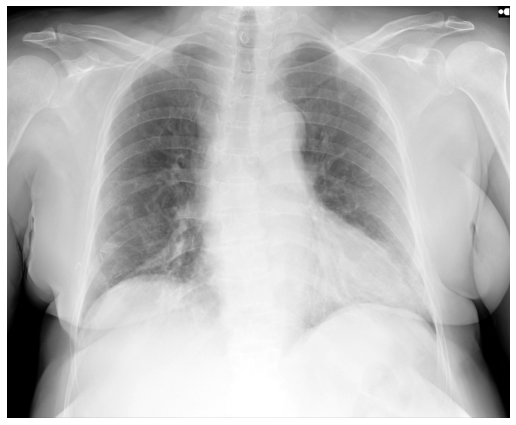

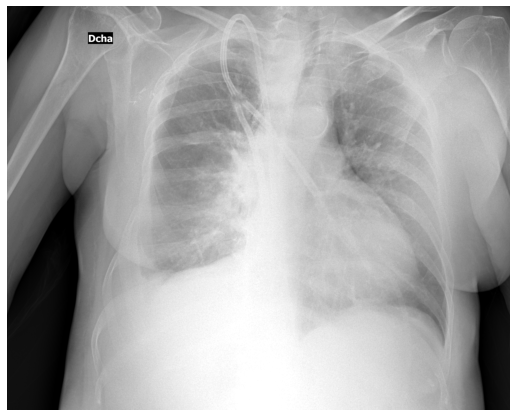

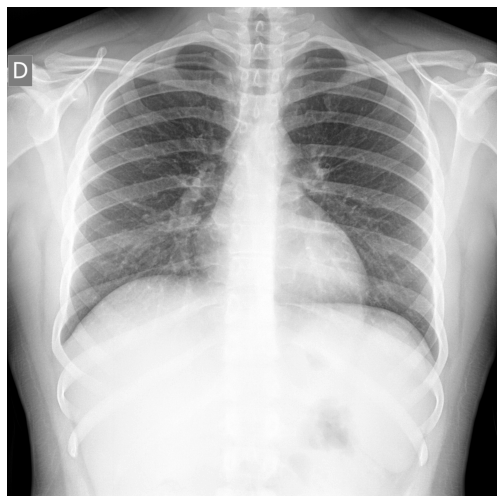

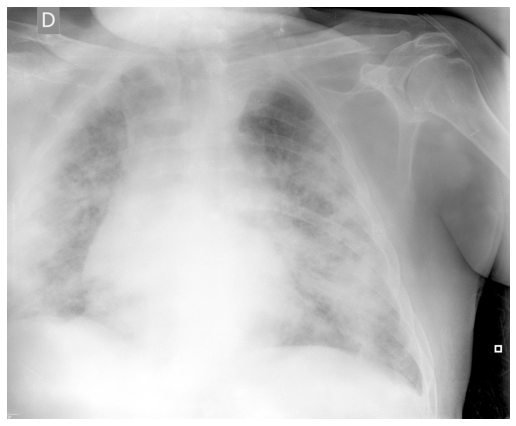

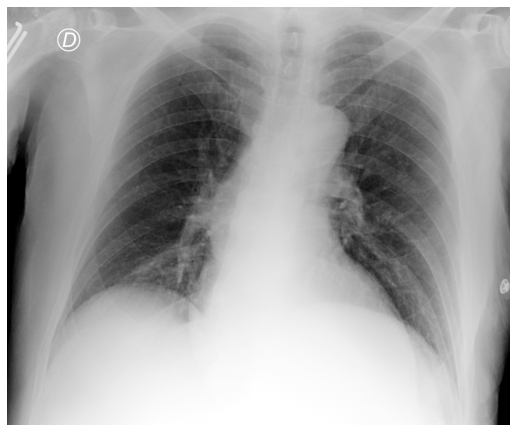

In [188]:
infos = []
for i in tqdm(range(len(df))):
    study = df['StudyInstanceUID'][i]
    image = df['id'][i].split('_')[0]

    study_path = os.path.join(DCM_PATH, DATABASE, study)
    series = os.listdir(study_path)
    
    found = False
    for s in series:
        img_path = os.path.join(study_path, s, image + ".dcm")
        if os.path.exists(img_path):
            found = True
            break
            
    if not found:
        print(f'Image {i} not found')
        continue
    
    img, meta = read_xray(img_path)
    shape = img.shape

    img, window = auto_windowing(img)
    img, crop_starts = remove_padding(img)

    if not (i % 500):
        plt.figure(figsize=(9, 9))
        plt.imshow(img, cmap="gray")
        plt.axis(False)
        plt.show()
        
    img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_LINEAR)
    
    save_name = f"{study}_{image}.png"
    cv2.imwrite(SAVE_DIR + save_name, img)

    info_dic = {
        "study_id": [study],
        "series_id": [s],
        "image_id": [image],
        "save_name": [save_name],
        "shape": [shape],
        "window": [window],
        "crop_starts": [crop_starts],
        "photometric_interpreation": [meta.PhotometricInterpretation],
        "series_number": [meta.SeriesNumber],
        "instance_number": [meta.InstanceNumber],
    }
    infos.append(pd.DataFrame.from_dict(info_dic))

#     break

infos = pd.concat(infos).reset_index(drop=True)
infos.to_csv(DATA_PATH + f'df_{DATABASE}_{SIZE}.csv', index=False)

In [ ]:
infos.head()